,,

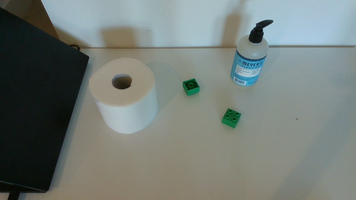
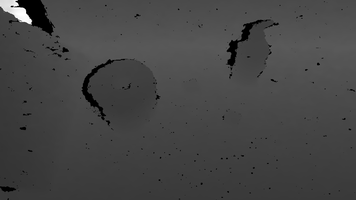
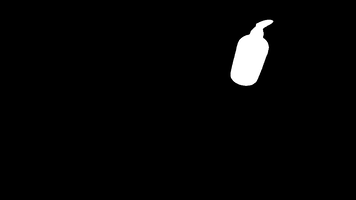

In [5]:
from PIL import Image
import numpy as np
import mediapy as media


rgb = Image.open("./../data/scene/rgb.png")
depth = Image.open("./../data/scene/depth.png")
mask = Image.open("./../data/scene/mask.png")

cam_K = np.loadtxt("./../data/scene/cam_K.txt").reshape(3,3)

mesh_name = "hand_soap"

mesh_obj_path = f"./../data/meshes/{mesh_name}/mesh.obj"
mesh_mtl_path = f"./../data/meshes/{mesh_name}/mesh.obj.mtl"
mesh_png_path = f"./../data/meshes/{mesh_name}/texture.png"

media.show_images([rgb, depth, mask], height=200)

In [6]:
from trlc_sdk.http.client import HTTPClient
from trlc_sdk.utils.network import encode_file, encode_image

client = HTTPClient()
results = client.estimate_pose(
    rgb_base64=encode_image(rgb),
    depth_base64=encode_image(depth),
    mask_base64=encode_image(mask),
    cam_K=cam_K.tolist(),
    mesh_obj=encode_file(mesh_obj_path),
    mesh_mtl=encode_file(mesh_mtl_path),
    mesh_png=encode_file(mesh_png_path)
)

pose = np.array(results["results"]).reshape(4,4)
print(pose)

[[-0.96055299  0.00259967  0.27808455  0.16851388]
 [-0.2250694  -0.59460855 -0.77187067 -0.05613203]
 [ 0.16334487 -0.80401111  0.57173824  0.64571548]
 [ 0.          0.          0.          1.        ]]


posed_3d_box,xyz_axis

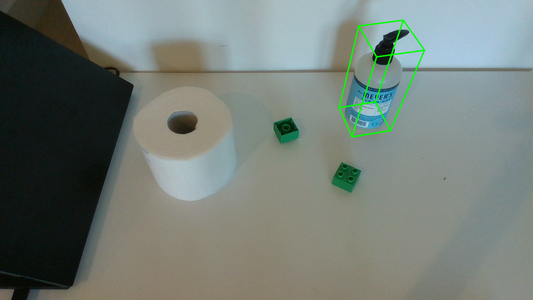
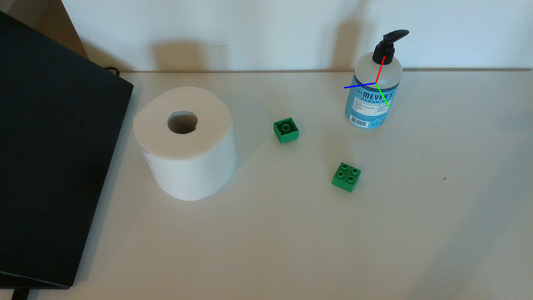

In [8]:
import trimesh
from trlc_sdk.utils.visualization import draw_posed_3d_box, draw_xyz_axis

mesh = trimesh.load(mesh_obj_path)
to_origin, extents = trimesh.bounds.oriented_bounds(mesh)
bbox = np.stack([-extents/2, extents/2], axis=0).reshape(2,3)

center_pose = pose@np.linalg.inv(to_origin)

visualization = {
    "posed_3d_box": draw_posed_3d_box(
        K=cam_K, 
        img=np.array(rgb), 
        ob_in_cam=center_pose, 
        bbox=bbox, 
        line_color=(0,255,0), 
        linewidth=2
    ),
    "xyz_axis": draw_xyz_axis(
        color=np.array(rgb), 
        ob_in_cam=center_pose, 
        K=cam_K, 
        thickness=2,
        scale=0.05
    )
}
media.show_images(visualization, height=300)